# Recommendation System for Amazon Clothing Products
---
## 5. Collaborative Recommendation System 

*Author*: Mariam Elsayed

*Contact*: mariamkelsayed@gmail.com

*Notebook*: 5 of 5

*Previous Notebook*: `content_rec.ipynb`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD

from surprise import accuracy
from surprise.model_selection import train_test_split

## Table of Contents

* [Introduction](#intro)

* [Loading the Data](#loading)

* [Collaborative Recommendation Systems](#colab)

    * [Creating User-Item Utility Matrix](#matrix)

    * [Using FunkSVD](#funksvd)

* [Conclusion](#conc)

## Introduction <a class="anchor" id="intro"></a>

A collaborative recommendation system relies on recommending products a similar user has liked. This

## Loading Data

In [2]:
# Loading 
reviews_df = pd.read_csv('Data/reviews_sampled40.csv')

In [3]:
reviews_df = reviews_df.drop_duplicates()
reviews_df

,overall,vote,reviewTime,reviewerID,asin,reviewText,summary
0,3,3,2016-06-20,A3EHNOVMY77W0U,B0001N5WMW,Bought them for a vacation to Costa Rica. Not ...,Lower quality than expected
1,5,0,2013-07-08,A3NNMXQ7P1HEHP,B00020BFSE,"Smells great, works fine with my size 9 work s...","Great, though I wonder how strong the loop is"
2,5,0,2017-06-06,AYJ7HFE42ZZFS,B0009B35DY,Good,Five Stars
3,5,0,2012-12-25,A1U04XCUUGJMDL,B0002L0P9I,"This slipper is perfect. It is true to size, ...",Warm Feet on Bamboo
4,5,0,2018-04-26,A1U28WCOIZ2SSI,B0002TOZ1E,great,Five Stars
...,...,...,...,...,...,...,...
5865968,5,0,2018-06-15,A13XFA6HDDHXQK,B01HH6WWZ0,Super cute. Fits great!,Five Stars
5865969,3,0,2018-03-04,AXETI2EZT77G0,B01HJCNFDU,these shoes seem like they could be so comfort...,these shoes seem like they could be so comfort...
5865970,4,0,2017-04-10,A13QWLE4LR3N01,B01GD5EPR4,"Very nice purse, fits a lot of cards and has a...",Lovely!
5865971,5,0,2018-07-18,A1CEK51A1EZDQ7,B01HHA3X04,I bought these for my girlfriend and she loves...,"Comfortable and comes as pictured, but runs la..."


In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5864455 entries, 0 to 5865972
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   overall     int64 
 1   vote        int64 
 2   reviewTime  object
 3   reviewerID  object
 4   asin        object
 5   reviewText  object
 6   summary     object
dtypes: int64(2), object(5)
memory usage: 357.9+ MB


### Preparing Data 

Collaborative recommendation systems rely on reviewers who have reviewed other items, so let's filter for reviews made by reviewers who have written at least 50 reviews.

In [5]:
reviews_df_mt50 = reviews_df.groupby('reviewerID').filter(lambda x:x['overall'].count() >= 50)

In [6]:
reviews_df_mt50

,overall,vote,reviewTime,reviewerID,asin,reviewText,summary
1125,1,0,2017-11-07,A3MPHEJ0N39W87,B00028AZ6E,Most pants on this size for very well...but NO...,Duckies Mens Original 874 Work Pants Black 36W...
3130,2,0,2015-12-08,A1YAP371XWJC6L,B0002PNK9Q,WAY too small! I couldn't even get them up to ...,Check the sizing chart before ordering.
3938,4,0,2017-06-03,A3MPHEJ0N39W87,B0009G6BN0,Nice casual shirt. Wash a few times before wea...,Fruit of the Loom Adult 5 oz. Long-Sleeve T-sh...
13231,5,0,2015-06-18,A3W5A9X3HHACQT,B0002NZ28A,LOVE THE COLOR!! SO SOFT AND COMFY! I AM 5'10-...,GREAT COLOR/FIT
25238,5,0,2016-08-24,A3MPHEJ0N39W87,B0002LT6RU,"Great shoes for my man who needs good, solid s...",Five Stars
...,...,...,...,...,...,...,...
5842894,5,0,2018-03-06,ALFRMOGTO1K4M,B01FKMG7ZO,very warm and i got a great deal,Five Stars
5844093,5,4,2017-01-19,A3J5XBZ9ZNEZOC,B01FILTPHE,"Had to size up b/c of Junior sizing however, t...",this dress is GREAT and pockets are a bonus
5844268,3,0,2017-06-04,A1P62PK6QVH8LV,B01GY0SBLY,Ok,Three Stars
5845790,5,0,2017-09-07,A3LV42NBFM829N,B01HGII8P2,good,Five Stars


In [8]:
reviews_df_mt50_cols = reviews_df_mt50[['asin', 'reviewerID', 'overall']]

In [9]:
reviews_df_mt50_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1330 entries, 1125 to 5851820
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   asin        1330 non-null   object
 1   reviewerID  1330 non-null   object
 2   overall     1330 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 41.6+ KB


## Collaborative Recommendation System <a class="anchor" id="colab"></a>

A collaborative recommendation system finds similar users and recommends what other similar users like as well. 

### Creating User-Item Utility Matrix <a class="anchor" id="utility"></a>

The user-item utility matrix is a table that shows the rating a user gave on a product. If the user did not review a product, then the value is null. T 
We can use this table to find similar users and make collaborative recommendations baised on that, however the matrix we have is too sparse.

In [10]:
# making user-item utility matrix
R_df = reviews_df_mt50_cols.pivot_table(values='overall', index='asin', columns='reviewerID').T

In [11]:
R_df

asin,B0000ANHT7,B0001YRE04,B0001YRFS0,B00028AVDG,B00028AZ6E,B0002LT6RU,B0002MFOPM,B0002NYQO6,B0002NZ28A,B0002PNJWE,...,B01H2B6TYK,B01H3EALTK,B01H3EB71G,B01H6ZS2FQ,B01H7EO598,B01H87VJPW,B01HAUL8HG,B01HFJOM70,B01HGII8P2,B01HHAT9M0
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1J7RPYGVGH5O3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1P62PK6QVH8LV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
A1YAP371XWJC6L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ENL8SWTHBOP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
A34SPFZIHHN907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3EGFSX6FQHWQ1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
A3G5KDMFNRUXHB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3J5XBZ9ZNEZOC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3JBQHQZEZPQK4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
products_1st_user_rated = ~R_df.iloc[10, :].isna()
products_2nd_user_rated = ~R_df.iloc[16, :].isna()

products_both_users_rated = products_1st_user_rated & products_2nd_user_rated
print(products_both_users_rated.sum())

1


In [13]:
R_df.sum(axis=1).sort_values(ascending=False)

reviewerID
ALFRMOGTO1K4M     484.0
A3W5A9X3HHACQT    416.0
AENH50GW3OKDA     324.0
A3LV42NBFM829N    323.0
AQR8WLMVKCE6V     313.0
A3J5XBZ9ZNEZOC    295.0
A1J7RPYGVGH5O3    290.0
AJ7VVCALVT8KP     260.0
AAC2BU2V9X95K     258.0
A3JBQHQZEZPQK4    258.0
AZZXCFBNEWIBQ     247.5
AOTJ1TVF87U4L     245.0
A3MPHEJ0N39W87    238.0
A34SPFZIHHN907    235.0
A3OXB8POGTLMFY    232.0
A2ENL8SWTHBOP2    229.0
A3EGFSX6FQHWQ1    218.0
A3G5KDMFNRUXHB    215.0
A8OYDQ9LKGI5W     214.0
A1YAP371XWJC6L    214.0
A1P62PK6QVH8LV    195.0
dtype: float64

In [14]:
products_1st_user_rated = ~R_df.loc['ALFRMOGTO1K4M'].isna()
products_2nd_user_rated = ~R_df.loc['A1P62PK6QVH8LV'].isna()

products_both_users_rated = products_1st_user_rated & products_2nd_user_rated
print(products_both_users_rated.sum())

1


In [15]:
products_both_users_rated[products_both_users_rated == True]

asin
B007C22YU8    True
dtype: bool

### Using FunkSVD<a class="anchor" id="funksvd"></a>

FunkSVD works around the user-utility matrix mostly being null by ignoring these missing values and compute the latent factors with values that are known.

In [16]:
reviews_df_simple = reviews_df[['reviewerID', 'asin', 'overall']].sort_values(by=['reviewerID', 'asin', 'overall'])
reviews_df_simple 

,reviewerID,asin,overall
5310286,A0000040I1OM9N4SGBD8,B00NX2IHS4,2
1635510,A0001170GCHUTHLVFXBQ,B006OR82F8,4
1528649,A0001392JPQ8N7MSF2CV,B005MZDI9I,5
5051923,A0001624UKLQG4OFIM8X,B00DE51XYA,5
1604496,A0002696N8BSFGJBGVFN,B005P19SCU,5
...,...,...,...
430388,AZZZV0D9D5V05,B000WTOCS0,5
1855597,AZZZY1W55XHZR,B00842Z7IG,1
3385423,AZZZYAYJQSDOJ,B00PQYM6AC,5
2098807,AZZZZHRHTLH4R,B00ARZHPBU,1


In [17]:
my_dataset = Dataset.load_from_df(reviews_df_simple, Reader(rating_scale=(1, 5)))
my_train_dataset = my_dataset.build_full_trainset()

In [18]:
my_train_dataset

In [19]:
my_algorithm = FunkSVD(n_factors=10, n_epochs=100, lr_all=0.1, biased=False, verbose=0)

my_algorithm.fit(my_train_dataset)

In [20]:
U = my_algorithm.pu     # user matrix
P = my_algorithm.qi.T   # products matrix

In [21]:
print(P.shape, 'P shape')
print(U.shape, 'U shape')

(10, 476136) P shape
(3943689, 10) U shape


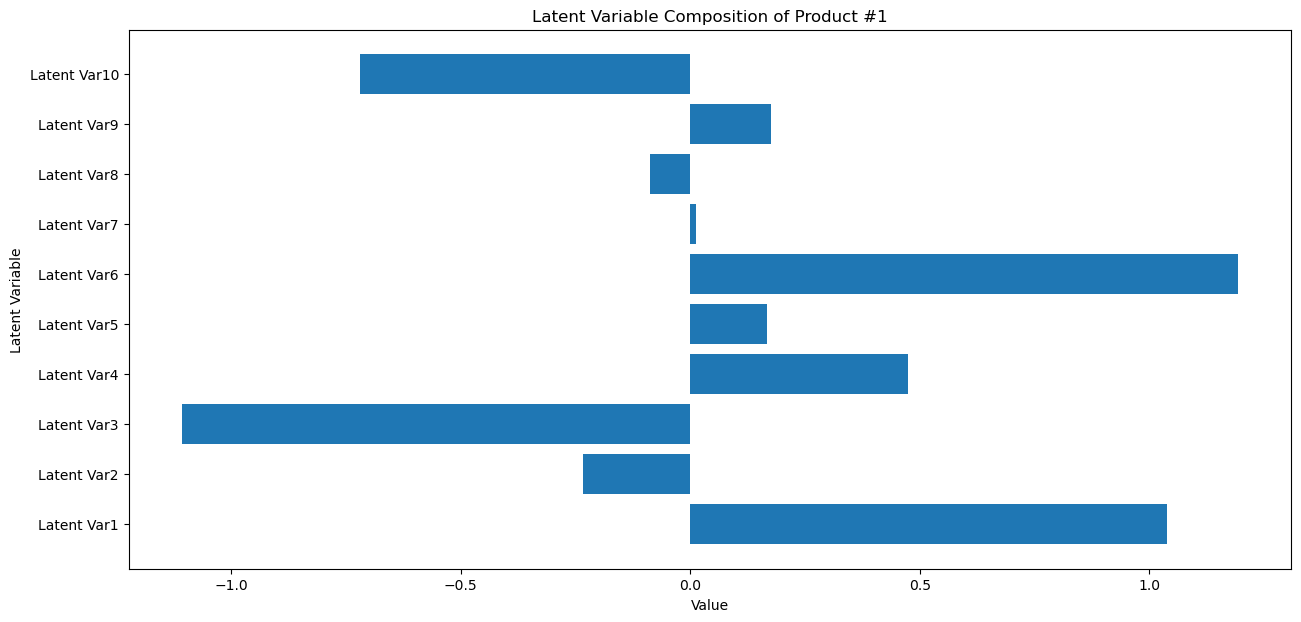

In [22]:
first_product = P[:, 0]

plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_product)+1)], first_product)
plt.title("Latent Variable Composition of Product #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

In [23]:
inner_user_id = my_train_dataset.to_inner_uid('A3FU9ZL7Z2R4PV') # find the inner representation of user 1
user_profile = U[inner_user_id]
user_profile

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [24]:
my_train_datasetx, my_test_dataset = train_test_split(my_dataset, test_size=0.5)

predictions = my_algorithm.test(my_test_dataset)

In [25]:
# Root Mean Squared Error
RMSE = accuracy.rmse(predictions, verbose=False)
print(RMSE)

1.406868799707259


In [26]:
# Mean Squared Error
MSE = accuracy.mse(predictions, verbose=False)
print(MSE)

1.9792798195897439


In [27]:
# Mean Average Error
MAE = accuracy.mae(predictions, verbose=False)
print(MAE)

0.7503042862027287


In [28]:
# FCP - Fraction of Concordant Pairs, the fraction of pairs whose relative ranking order is correct
FCP = accuracy.fcp(predictions, verbose=False)
print(FCP) 

0.31204435897179394


The error is not the worst and atleast we are getting some fraction of concordant pairs.

Now let's increase the number of latent variables and see if this effects the accuracy scores.

In [29]:
my_algorithm = FunkSVD(n_factors=30, n_epochs=100, lr_all=0.1, biased=False, verbose=0)

my_algorithm.fit(my_train_dataset)

In [30]:
U = my_algorithm.pu
P = my_algorithm.qi.T

In [31]:
print(P.shape, 'P shape')
print(U.shape, 'U shape')

(30, 476136) P shape
(3943689, 30) U shape


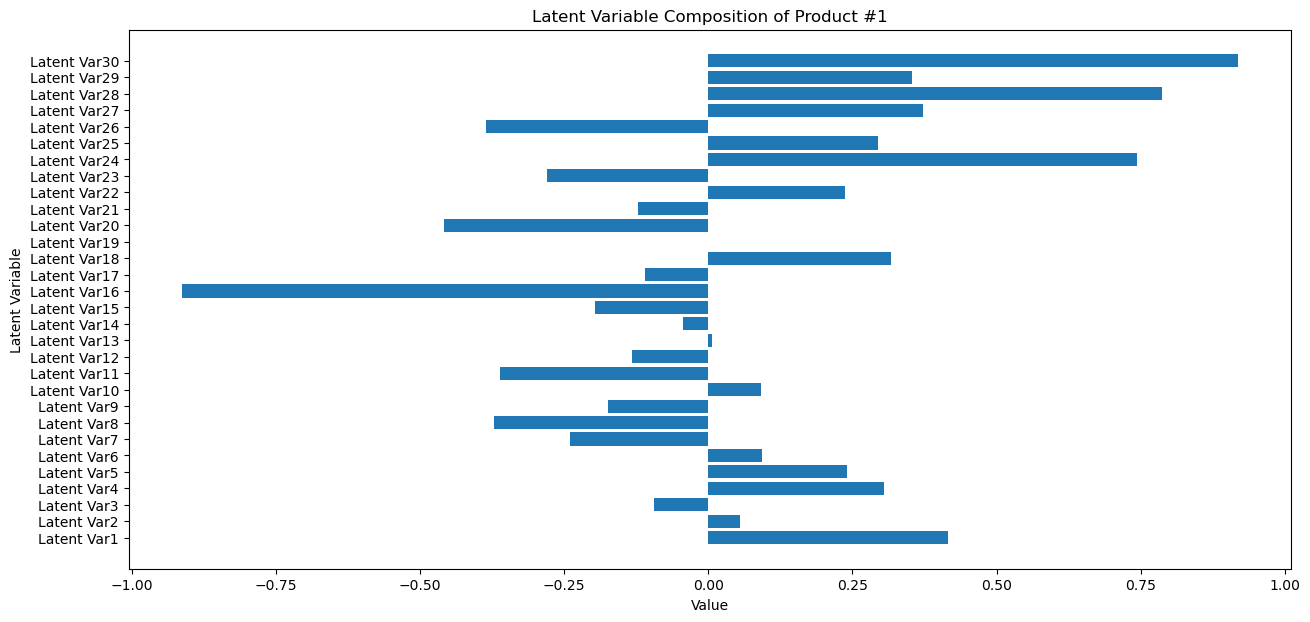

In [32]:
first_product = P[:, 0]

plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_product)+1)], first_product)
plt.title("Latent Variable Composition of Product #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

In [33]:
inner_user_id = my_train_dataset.to_inner_uid('A3FU9ZL7Z2R4PV') # find the inner representation of user 1
user_profile = U[inner_user_id]
user_profile

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [34]:
my_train_datasetx, my_test_dataset = train_test_split(my_dataset, test_size=0.5)

predictions = my_algorithm.test(my_test_dataset)

In [35]:
RMSE = accuracy.rmse(predictions, verbose=False)
print(RMSE)

1.4064703988707468


In [36]:
MSE = accuracy.mse(predictions, verbose=False)
print(MSE)

1.9781589828996375


In [37]:
MAE = accuracy.mae(predictions, verbose=False)
print(MAE)

0.7499895374284411


In [38]:
# FCP - Fraction of Concordant Pairs, the fraction of pairs whose relative ranking order is correct

FCP = accuracy.fcp(predictions, verbose=False)
print(FCP) 

0.3079913351853821


Increasing the number of latent variables does not make a difference with improving the error or the fraction of concordant pairs.

## Conclusion <a class="anchor" id="conc"></a>

Using FunkSVD, a collaborative recommendation system was created with the fraction of pairs whose relative ranking order being correct at 0.31. 